<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [2]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Dataset, Data


### Load Data

In [3]:
dataRoot = "/data"

In [4]:
heritability = "/h40"

In [4]:
data = torch.load(dataRoot + heritability + "/graph_maf_hetero.pt")

In [5]:
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

In [6]:
#df_snp_pheno_ped = pd.read_parquet(dataRoot + heritability + '/snp_maf_one_hot_ped.parquet', engine='pyarrow')
df_snp_pheno_ped = pd.read_parquet(dataRoot + heritability + '/snp_maf_one_hot_ped_gen30.parquet', engine='pyarrow')

In [7]:
df_snp_sire = pd.read_parquet(dataRoot + heritability + '/snp_sire_BPpos_maf_one_hot_gen30.parquet', engine='pyarrow')

In [8]:
df_snp_gen30_ped = pd.read_parquet(dataRoot + heritability + '/snpTruePheno_gen30_BPpos_maf_one_hot_ped.parquet', engine='pyarrow')

In [9]:
df_pheno = pd.read_csv(phenotype_path , sep=" ", header=None, names=["id", "fixed_effect", "phenotype"])

In [10]:
df_pheno.drop(["fixed_effect"], axis=1, inplace = True)

In [11]:
true_pheno = df_snp_gen30_ped[['id', 'phenotype']].copy()

In [12]:
pheno_result_df = pd.concat([df_pheno, true_pheno], ignore_index=True)
df_pheno = pheno_result_df

In [13]:
df_ids = df_snp_pheno_ped[["id"]]
df_snp_temp = df_snp_pheno_ped.drop(["id", "phenotype", "sire", "dam", "generation", "sex"], axis=1)

In [14]:
# with sire genotype
df_sire_ids = df_snp_sire[["id"]]
df_snp_sire_temp = df_snp_sire.drop(["id"], axis=1)

In [18]:
result_df = pd.concat([df_snp_temp, df_snp_sire_temp], ignore_index=True)

In [19]:
result_id_df = pd.concat([df_ids, df_sire_ids], ignore_index=True)

In [15]:
snp_array = df_snp_temp.to_numpy()

In [16]:
snp_sire_array = df_snp_sire_temp.to_numpy()

In [17]:
# Reshape the data back to its original shape
snp_one_hot = snp_array.reshape(df_snp_temp.shape[0], int(df_snp_temp.shape[1]/3), 3)

In [27]:
snp_one_hot_sire = snp_sire_array.reshape(df_snp_sire_temp.shape[0], int(df_snp_sire_temp.shape[1]/3), 3)

## Graph Generation

In [20]:
animal_ids = df_snp_pheno_ped['id'].unique()
dam_ids = df_snp_pheno_ped['dam'].unique()
sire_ids = df_snp_pheno_ped['sire'].unique()

In [21]:
#id_to_index = {id: index for index, id in enumerate({*animal_ids, *dam_ids, *sire_ids})}
id_to_index = {id: index for index, id in enumerate({*animal_ids, *dam_ids})}

In [22]:
index_to_id = {index: id for id, index in id_to_index.items()}

In [23]:
id_to_index_sire = {id: index for index, id in enumerate(sire_ids)}
index_to_id_sire = {index: id for id, index in id_to_index_sire.items()}

In [24]:
# dictinary of id to one hot encoded snp sequence
id_to_snp_one_hot = dict(zip(df_ids["id"], torch.from_numpy(snp_one_hot)))

# replace the id ind id_to_snp_one_hot with the corresponding index in id_to_index
index_to_snp_one_hot = {id_to_index[id]: snp for id, snp in id_to_snp_one_hot.items()}

In [29]:
# with sire genotype
# dictinary of id to one hot encoded snp sequence
id_to_snp_one_hot_sire = dict(zip(df_sire_ids["id"], torch.from_numpy(snp_one_hot_sire)))

# replace the id ind id_to_snp_one_hot with the corresponding index in id_to_index
index_to_snp_one_hot_sire = {id_to_index_sire[id]: snp for id, snp in id_to_snp_one_hot_sire.items()}

In [30]:
#num_features = len([col for col in df_snp_pheno_ped.columns if col.startswith('snp_')])
num_features = snp_one_hot.shape[1]

#node_features = torch.tensor(np.full((len(id_to_index), num_features), np.nan), dtype=torch.float16) # ordinally encoded
#node_features = torch.tensor(np.full((len(id_to_index), num_features, 3), np.nan), dtype=torch.float16) # one-hot encoded
node_features = torch.zeros(len(id_to_index), num_features, 3) # one-hot encoding

node_labels = torch.tensor(np.full(len(id_to_index), np.nan), dtype=torch.float32)

In [31]:
#num_features = len([col for col in df_snp_pheno_ped.columns if col.startswith('snp_')])
num_features_sire = snp_one_hot_sire.shape[1]

#node_features = torch.tensor(np.full((len(id_to_index), num_features), np.nan), dtype=torch.float16) # ordinally encoded
#node_features = torch.tensor(np.full((len(id_to_index), num_features, 3), np.nan), dtype=torch.float16) # one-hot encoded
node_features_sire = torch.zeros(len(id_to_index_sire), num_features_sire, 3) # one-hot encoding

node_labels_sire = torch.tensor(np.full(len(id_to_index_sire), np.nan), dtype=torch.float32)

In [32]:
# replace the values in node_features whith the values from index_to_snp_one_hot by the corresponding index
for index, snp in index_to_snp_one_hot.items():
    node_features[index] = snp

In [33]:
for index, snp in index_to_snp_one_hot_sire.items():
    node_features_sire[index] = snp

In [34]:
# get indices from id_to_index with animal_ids and convert to tensor
animal_indices = torch.tensor([id_to_index[id] for id in animal_ids])

In [38]:
# Create edge indices
valid_dam_indices = df_snp_pheno_ped['dam'].map(id_to_index).notna()
valid_sire_indices = df_snp_pheno_ped['sire'].map(id_to_index_sire).notna()
#animal_indices = animal_indices[valid_animal_indices]

dam_indices = torch.tensor(df_snp_pheno_ped.loc[valid_dam_indices, 'dam'].map(id_to_index))
sire_indices = torch.tensor(df_snp_pheno_ped.loc[valid_sire_indices, 'sire'].map(id_to_index_sire))

#edge_indices = torch.cat((animal_indices, dam_indices)).view(2, len(animal_indices))


In [39]:
from torch_geometric.data import HeteroData

data = HeteroData()

In [40]:
data['female'].x = node_features
data['male'].x = node_features_sire
#data['male'].x = torch.zeros(len(id_to_index_sire), num_features, 3)

In [41]:
data['male'].x.shape

torch.Size([2000, 26282, 3])

In [20]:
data['male'].x.shape

torch.Size([1820, 26282, 3])

In [42]:
data['female'].y = node_labels
data['male'].y = torch.tensor(np.full(len(id_to_index_sire), np.nan), dtype=torch.float32)

In [43]:
data['female', 'inherits', 'female'].edge_index = torch.stack((dam_indices, animal_indices))
data['male', 'inherits', 'female'].edge_index = torch.stack((sire_indices, animal_indices))

In [44]:
data['female'].node_ids = torch.tensor([index_to_id[index] for index in range(len(index_to_id))])
data['male'].node_ids = torch.tensor([index_to_id_sire[index] for index in range(len(index_to_id_sire))])

In [46]:
# Assing label to dam nodes without features but labels

id_pheno_dict = df_pheno.set_index('id')['phenotype'].astype(float).to_dict()

labels = [id_pheno_dict.get(node_id.item(), float('nan')) for node_id in data['female'].node_ids]
labels = torch.tensor(labels, dtype=torch.float32)

data['female'].y = labels

In [47]:
data

HeteroData(
  female={
    x=[282992, 26282, 3],
    y=[282992],
    node_ids=[282992]
  },
  male={
    x=[2000, 26282, 3],
    y=[2000],
    node_ids=[2000]
  },
  (female, inherits, female)={ edge_index=[2, 252000] },
  (male, inherits, female)={ edge_index=[2, 252000] }
)

In [25]:
data

HeteroData(
  female={
    x=[240992, 26282, 3],
    y=[240992],
    node_ids=[240992]
  },
  male={
    x=[1820, 26282, 3],
    y=[1820],
    node_ids=[1820]
  },
  (female, inherits, female)={ edge_index=[2, 210000] },
  (male, inherits, female)={ edge_index=[2, 210000] }
)

In [26]:
y_has_nans = torch.isnan(data['female'].y)

In [27]:
y_has_nans = torch.isnan(data['male'].y)

In [ ]:
# load data
#data = torch.load("data.pt")

In [55]:
import torch

def split_data(_data, val_size=0.2, test_size=0.1, random_seed=42):
    # Set the random seed for reproducibility
    torch.manual_seed(random_seed)

    # Check if data.y contains NaN values
    y_has_nans = torch.isnan(_data['female'].y)

    # Check if data.x has only zeros
    x_has_only_zeros = torch.sum(_data['female'].x, dim=(1, 2)) == 0

    # Combine the conditions using logical OR
    has_nans = y_has_nans | x_has_only_zeros

    # Combine the conditions using logical OR
    has_nans = y_has_nans | x_has_only_zeros

    # Negate the boolean tensor to get the desired result
    has_no_nans = ~has_nans

    # Identify the indices where 'has_no_nans' is True
    true_indices = torch.where(has_no_nans)[0]

    # Determine the number of indices to change
    num_indices = len(true_indices)
    num_test_indices = int(num_indices * test_size)
    num_val_indices = int(num_indices * val_size)

    # Generate random indices for test, validation, and train sets
    indices = torch.randperm(num_indices)
    test_indices = true_indices[indices[:num_test_indices]]
    val_indices = true_indices[indices[num_test_indices:num_test_indices + num_val_indices]]
    train_indices = true_indices[indices[num_test_indices + num_val_indices:]]

    # Create the masks
    train_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)
    val_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)
    test_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    return train_mask, val_mask, test_mask

def split_data_Gen30(_data, val_size=0.2, test_size=0.1, random_seed=42):
    # Set the random seed for reproducibility
    torch.manual_seed(random_seed)

    # Check if data.y contains NaN values
    y_has_nans = torch.isnan(_data['female'].y)

    # Check if data.x has only zeros
    x_has_only_zeros = torch.sum(_data['female'].x, dim=(1, 2)) == 0

    
    # Convert the 'id' column of the DataFrame to a Python set for faster lookup
    snp_ids_set = set(df_snp_gen30_ped['id'])

    # Convert the tensor to a Python list or numpy array to iterate through
    node_ids_list = _data['female'].node_ids.tolist()

    # Create a list of boolean values indicating if an ID is in the snp_ids_set
    bool_list = [id_item in snp_ids_set for id_item in node_ids_list]

    # Convert the list to a boolean tensor
    bool_tensor_gen30 = torch.tensor(bool_list, dtype=torch.bool)
    
    
    # Combine the conditions using logical OR
    has_nans = y_has_nans | x_has_only_zeros | bool_tensor_gen30

    # Negate the boolean tensor to get the desired result
    has_no_nans = ~has_nans

    # Identify the indices where 'has_no_nans' is True
    true_indices = torch.where(has_no_nans)[0]

    # Determine the number of indices to change
    num_indices = len(true_indices)
    num_test_indices = int(num_indices * test_size)
    num_val_indices = int(num_indices * val_size)

    # Generate random indices for test, validation, and train sets
    indices = torch.randperm(num_indices)
    test_indices = true_indices[indices[:num_test_indices]]
    val_indices = true_indices[indices[num_test_indices:num_test_indices + num_val_indices]]
    train_indices = true_indices[indices[num_test_indices + num_val_indices:]]

    # Create the masks
    train_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)
    val_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)
    test_mask = torch.zeros_like(has_no_nans, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    return train_mask, val_mask, test_mask, bool_tensor_gen30

train_mask, val_mask, test_mask, gen30_mask = split_data_Gen30(data, val_size=0.1, test_size=0.1, random_seed=42)
#train_mask, val_mask, test_mask = split_data(data, val_size=0.2, test_size=0.1, random_seed=42)

In [56]:
train_mask.sum()

tensor(168000)

In [57]:
val_mask.sum()

tensor(21000)

In [58]:
test_mask.sum()

tensor(21000)

In [59]:
gen30_mask.sum()

tensor(42000)

In [60]:
data['female'].train_mask = train_mask
data['female'].val_mask = val_mask
data['female'].test_mask = test_mask
data['female'].gen30_mask = gen30_mask

In [61]:
data

HeteroData(
  female={
    x=[282992, 26282, 3],
    y=[282992],
    node_ids=[282992],
    train_mask=[282992],
    val_mask=[282992],
    test_mask=[282992],
    gen30_mask=[282992]
  },
  male={
    x=[2000, 26282, 3],
    y=[2000],
    node_ids=[2000]
  },
  (female, inherits, female)={ edge_index=[2, 252000] },
  (male, inherits, female)={ edge_index=[2, 252000] }
)

In [62]:
# save data
torch.save(data, dataRoot + heritability + "/graph_maf_hetero_f32_gen30_SireGeno.pt")

In [38]:
import torch.nn.functional as F

def create_attention_mask(data, paddedLength=-1):

    # Create attention_mask (torch.FloatTensor of shape (batch_size, sequence_length)) for train and val
    attention_mask = torch.ones(data['female'].x.shape[0], data['female'].x.shape[1]).to('cpu')

    if(paddedLength != -1 and paddedLength > data['female'].x.shape[1]):
        pad = paddedLength - data['female'].x.shape[1]
        # Pad the data to the max length
        X_pad = np.pad(data['female'].x.to('cpu'), ((0,0),(0,pad),(0,0)), 'constant', constant_values=0)
        attention_mask = F.pad(attention_mask, (0,pad), 'constant', 0)

    data['female'].x_pad = torch.tensor(X_pad, dtype=torch.float16)
    data['female'].attention_mask = attention_mask

In [39]:
create_attention_mask(data, paddedLength=26624)

In [40]:
# save data
torch.save(data, dataRoot + heritability + "/graph_maf_hetero_attention.pt")

In [ ]:
labels

tensor([5.2656, 4.1680, 3.7168,  ..., 6.2188, 0.3118, 2.2480],
       dtype=torch.float16)

In [ ]:
# Get the index of the desired node_id in the node_ids tensor
node_index = (data['female'].node_ids == 11046).nonzero(as_tuple=False).squeeze()
node_index

tensor(1185)

In [ ]:
# Get the node id based on a index in data.edge_index
index = 0
node_id = data['female'].node_ids[data['female', 'inherits', 'female'].edge_index[index]]
node_id

In [ ]:
# Get the node id based on the index of the desired node
data['female'].node_ids[node_index]

tensor(11046)

In [ ]:

# Filter the edge_index tensor based on the node_index
edges = data['female', 'inherits', 'female'].edge_index[:, (data['female', 'inherits', 'female'].edge_index[0] == node_index) | (data['female', 'inherits', 'female'].edge_index[1] == node_index)]

# edges contains the edge indices connected to the node_id
print(edges)

tensor([[1535],
        [1185]])


In [ ]:
# get the node id to the specific edge index
print(data['female'].node_ids[edges])

tensor([[ 7564],
        [11046]])


In [ ]:
node_index

tensor(1269)

In [ ]:
# first 10 animal indices
animal_indices[:10]

tensor([181, 182, 183, 184, 185, 186, 187, 188, 189, 190])

In [ ]:
data['female'].y[1269]

tensor(2.8594, dtype=torch.float16)

In [ ]:
desired_index = 66

# Search for the index in id_to_index
for id, index in id_to_index.items():
    if index == desired_index:
        print("Found id with index", desired_index, ":", id)
        break
else:
    print("No id found with index", desired_index)


Found id with index 66 : 8534


In [3]:
# Print the information about the created graph data
print(data)

HeteroData(
  female={
    x=[1673, 49800, 3],
    y=[1673],
    node_ids=[1673],
    train_mask=[1673],
    val_mask=[1673],
    test_mask=[1673]
  },
  male={
    x=[95, 49800, 3],
    y=[95],
    node_ids=[95]
  },
  (female, inherits, female)={ edge_index=[2, 1000] },
  (male, inherits, female)={ edge_index=[2, 1000] }
)


In [ ]:
data.validate(raise_on_error=True)

True

In [ ]:
print(data.keys)

['test_mask', 'node_ids', 'x', 'edge_index', 'val_mask', 'y', 'train_mask']


In [ ]:
data['female']['y']

tensor([5.2656, 4.1680, 3.7168,  ..., 6.2188, 0.3118, 2.2480],
       dtype=torch.float16)

In [ ]:
#print(data['x'].unique())
#print(data['female'].x.unique())

In [32]:
'edge_attr' in data

False

In [33]:
data['female'].num_nodes

240992

In [34]:
data.num_node_features

{'female': 3, 'male': 3}

In [35]:
data.has_isolated_nodes()

False

In [36]:
data.has_self_loops()

False

In [37]:
data.is_directed()

False

In [38]:
type(data)

torch_geometric.data.hetero_data.HeteroData

In [ ]:
import torch
from torch_geometric.utils import contains_self_loops

# Check if the graph contains self-loops
has_self_loops = contains_self_loops(data['female', 'inherits', 'female'].edge_index)

if has_self_loops:
    # Find the indices of nodes with self-loops
    self_loop_indices = (data['female', 'inherits', 'female'].edge_index[0] == data['female', 'inherits', 'female'].edge_index[1]).nonzero().view(-1)
    nodes_with_self_loops = self_loop_indices.unique()

    print("Nodes with self-loops:")
    print(nodes_with_self_loops)
else:
    print("The graph does not contain any self-loops.")


The graph does not contain any self-loops.


In [ ]:
# get the highest node index
highest_node_index = data['female'].node_ids.max().item()
highest_node_index

11050

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create an empty NetworkX graph
graph = nx.DiGraph()

for node_id in data['female'].node_ids:
    graph.add_node(node_id.item(),  type='female')

for node_id in data['male'].node_ids:
    graph.add_node(node_id.item(), type='male')

for src, tgt in zip(data['female', 'inherits', 'female'].edge_index[0], data['female', 'inherits', 'female'].edge_index[1]):
    graph.add_edge(index_to_id[src.item()], index_to_id[tgt.item()], relation=("female", "inherits", "female"))

for src, tgt in zip(data['male', 'inherits', 'female'].edge_index[0], data['male', 'inherits', 'female'].edge_index[1]):
    graph.add_edge(index_to_id_sire[src.item()], index_to_id[tgt.item()], relation=("male", "inherits", "female"))

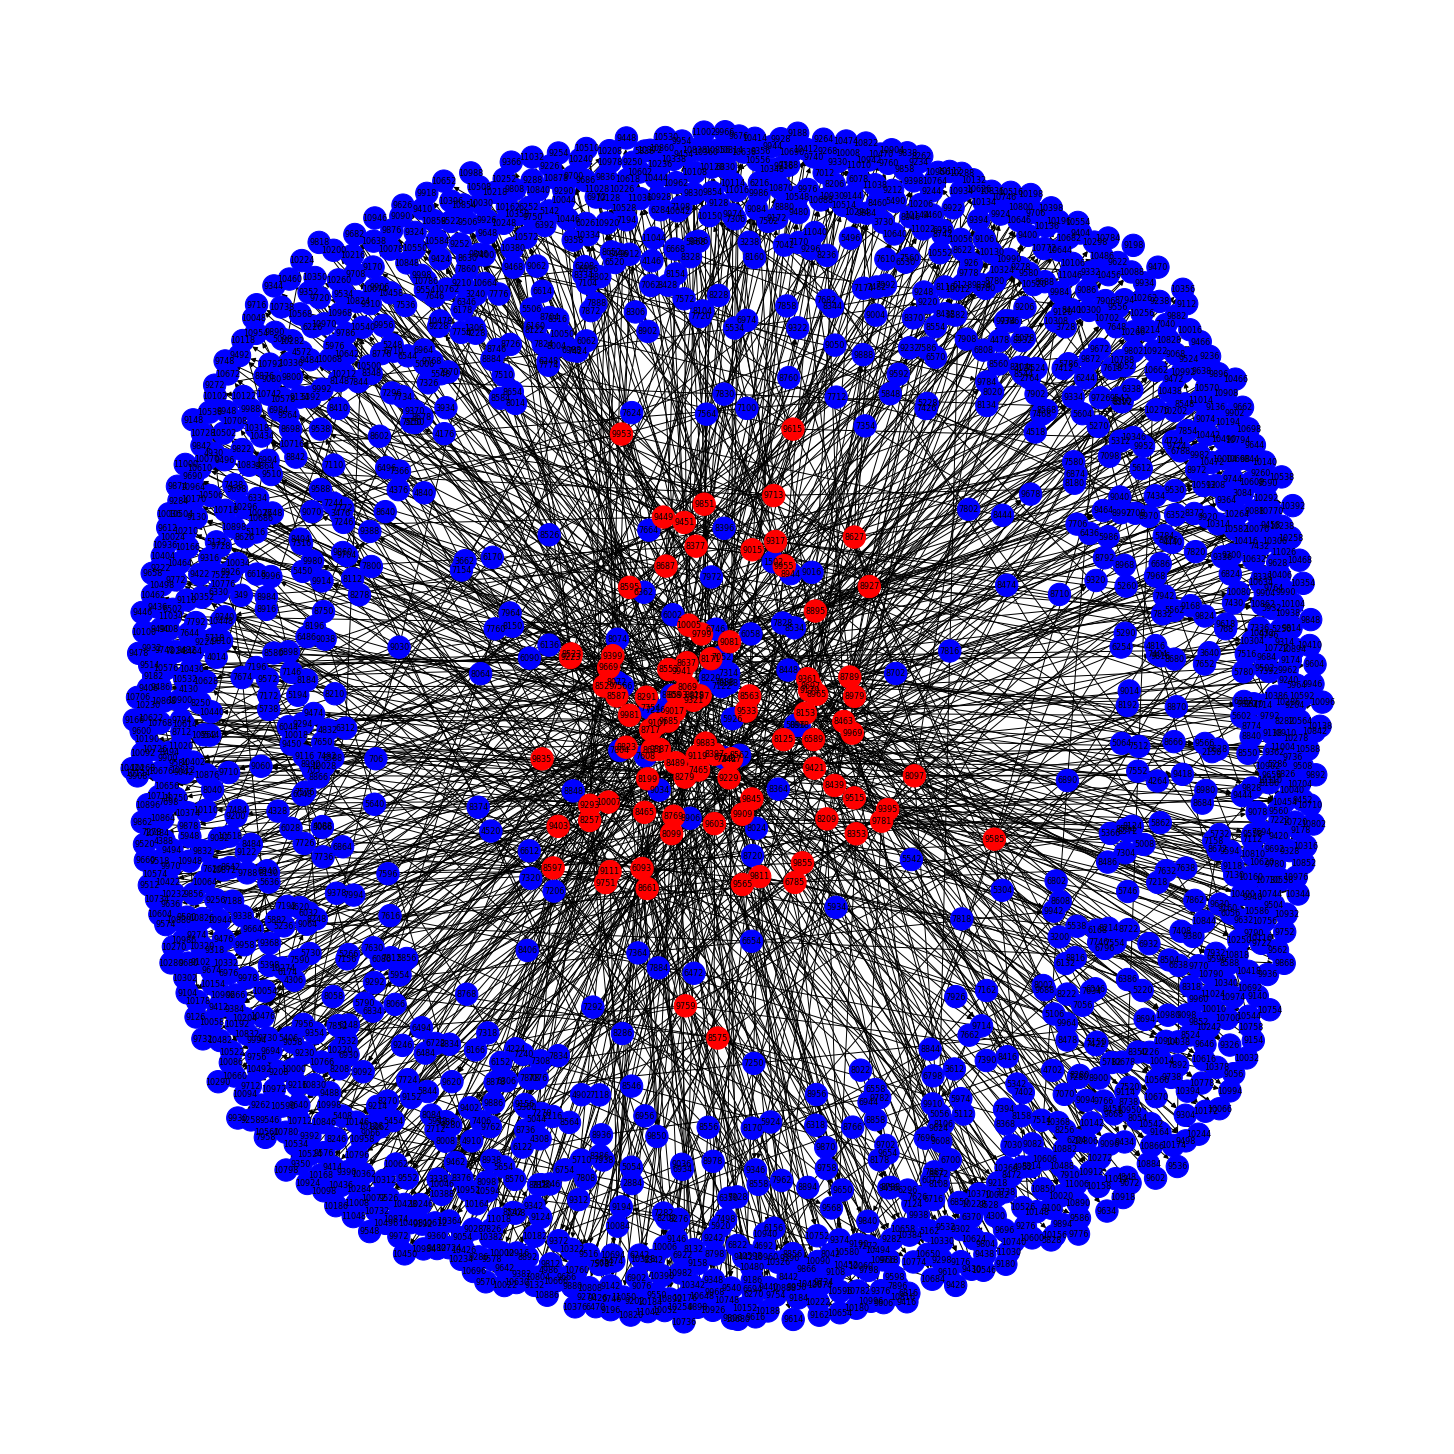

In [ ]:
# Draw the graph
pos = nx.layout.fruchterman_reingold_layout(graph)
node_colors = ['blue' if graph.nodes[node]['type'] == 'female' else 'red' for node in graph.nodes]

plt.figure(figsize=(20, 20))
nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
plt.show()

In [40]:
nan_indices = torch.isnan(data['female'].y)
nan_node_ids = torch.nonzero(nan_indices).squeeze()

print("Node IDs with NaN labels:")
print(len(nan_node_ids))


Node IDs with NaN labels:
0


In [43]:
#nan_indices = torch.isnan(data.x).any(dim=1)
nan_indices =  torch.isnan(data['male'].x).any(dim=2).any(dim=1)
nan_node_ids = torch.nonzero(nan_indices).squeeze()

print("Node IDs with NaN node features:")
print(len(nan_node_ids))


Node IDs with NaN node features:
0


In [13]:
data

HeteroData(
  female={
    x=[240992, 26282, 3],
    y=[240992],
    node_ids=[240992],
    train_mask=[240992],
    val_mask=[240992],
    test_mask=[240992]
  },
  male={
    x=[1820, 26282, 3],
    y=[1820],
    node_ids=[1820]
  },
  (female, inherits, female)={ edge_index=[2, 420000] },
  (male, inherits, female)={ edge_index=[2, 210000] },
  (female, rev_inherits, male)={ edge_index=[2, 210000] }
)

In [4]:
import torch
from torch_geometric.data import Dataset, Data

In [6]:
# load data
data = torch.load(dataRoot + heritability + "/graph_maf_hetero.pt")

In [7]:
reshaped_tensor = torch.zeros(data['male'].x.shape[0], 1)
data['male'].x = reshaped_tensor

In [9]:
data['male'].x.shape

torch.Size([1820, 1])

In [10]:
torch.save(data, dataRoot + heritability + "/graph_maf_hetero_maleX0.pt")

In [5]:
#https://github.com/pyg-team/pytorch_geometric/issues/7234
import torch_geometric.transforms as T
data = T.ToUndirected()(data)

In [12]:
data['female', 'inherits', 'female'].edge_index = data['female', 'inherits', 'female'].edge_index.flip([0])
data['male', 'inherits', 'female'].edge_index = data['male', 'inherits', 'female'].edge_index.flip([0])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Already send node features/labels to GPU for faster access during sampling:
data.to(device, 'x', 'y')
#filtered_data.to(device, 'x', 'y')

HeteroData(
  female={
    x=[1673, 49800, 3],
    y=[1673],
    node_ids=[1673],
    train_mask=[1673],
    val_mask=[1673],
    test_mask=[1673]
  },
  male={
    x=[95, 49800, 3],
    y=[95],
    node_ids=[95]
  },
  (female, inherits, female)={ edge_index=[2, 2000] },
  (male, inherits, female)={ edge_index=[2, 1000] },
  (female, rev_inherits, male)={ edge_index=[2, 1000] }
)

In [64]:
#data['male'].y.fill_(999)

tensor([999., 999., 999.,  ..., 999., 999., 999.], dtype=torch.float16)

In [9]:
kwargs = {'batch_size': 8, 'num_workers': 0, 'persistent_workers': False}

In [10]:
from torch_geometric.loader import NeighborLoader
import copy

In [11]:
train_loader = NeighborLoader(copy.copy(data), num_neighbors=[4] * 2, shuffle=True,
                                  input_nodes=('female', data['female'].train_mask), **kwargs)

In [47]:
val_loader = NeighborLoader(data, num_neighbors=[4] * 2, shuffle=False,
                                input_nodes=('female', data['female'].val_mask), **kwargs)

In [48]:

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=('female',None),
                                 num_neighbors=[-1], shuffle=False, **kwargs)

In [51]:
batch = next(iter(train_loader))

In [14]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from tqdm import tqdm

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        embeddings = []
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
            embeddings.append(x)
        return x.squeeze(), embeddings 

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        embeddings = []
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
            embeddings.append(x_all)
        pbar.close()
        return x_all.squeeze(), embeddings


In [12]:
from torch_geometric.nn import SAGEConv, Linear
import torch.nn.functional as F
from tqdm import tqdm

class SAGE_OneHot(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv((-1, -1), hidden_channels))
        #self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv((-1, -1), hidden_channels))
        self.linear = Linear(-1, 1)

    def forward(self, x, edge_index):
        embeddings = []
        # flatten the one-hot encoding
        x = x.flatten(start_dim=1)

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
            embeddings.append(x)
        x = self.linear(x)
        return x.squeeze(), embeddings 

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        embeddings = []
        x_all = x_all.flatten(start_dim=1)
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                with torch.cuda.amp.autocast():
                    x = x_all[batch.n_id.to(x_all.device)].to(device)
                    x = conv(x, batch.edge_index.to(device))
                    if i < len(self.convs) - 1:
                        x = x.relu_()
                    xs.append(x[:batch.batch_size].cpu())
                    pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
            embeddings.append(x_all)
        pbar.close()
        return x_all.squeeze(), embeddings

In [53]:
class SAGERegressionWithEmbeddings(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers = 3, dropout = 0.5):
        super(SAGERegressionWithEmbeddings, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout
        self.activation = torch.nn.Linear(out_channels, 1)  # Identity activation for regression

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        embeddings = []
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            embeddings.append(x)
        x = self.convs[-1](x, edge_index)
        regression_output = self.activation(x)  # Apply the chosen activation function for regression
        return regression_output, embeddings

    @torch.no_grad()
    def inference(self, x_all, val_loader):
        pbar = tqdm(total=len(val_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        embeddings = []
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in val_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
            embeddings.append(x_all)

        regression_output = self.activation(x_all).squeeze()  # Apply the chosen activation function for regression
        pbar.close()
        return regression_output, embeddings


In [20]:
from torch_geometric.nn import to_hetero

#model = SAGE(data.x.size(1), 256, 1).to(device)
model = SAGE_OneHot(data['female'].x.size(1)* data['female'].x.size(2), 256, 1)
model = to_hetero(model, data.metadata(), aggr='mean').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
criterion = torch.nn.MSELoss()

In [22]:
data

HeteroData(
  female={
    x=[240992, 26282, 3],
    y=[240992],
    node_ids=[240992],
    train_mask=[240992],
    val_mask=[240992],
    test_mask=[240992]
  },
  male={
    x=[1820, 1],
    y=[1820],
    node_ids=[1820]
  },
  (female, inherits, female)={ edge_index=[2, 420000] },
  (male, inherits, female)={ edge_index=[2, 210000] },
  (female, rev_inherits, male)={ edge_index=[2, 210000] }
)

In [39]:
train_loader.data

HeteroData(
  female={
    x=[240992, 26282, 3],
    y=[240992],
    node_ids=[240992],
    train_mask=[240992],
    val_mask=[240992],
    test_mask=[240992]
  },
  male={
    x=[1820, 256],
    y=[1820],
    node_ids=[1820]
  },
  (female, inherits, female)={ edge_index=[2, 420000] },
  (male, inherits, female)={ edge_index=[2, 210000] },
  (female, rev_inherits, male)={ edge_index=[2, 210000] }
)

In [ ]:
train_loader.num_workers


0

In [16]:
batch = next(iter(train_loader))
batch

HeteroData(
  female={
    x=[79, 26282, 3],
    y=[79],
    node_ids=[79],
    train_mask=[79],
    val_mask=[79],
    test_mask=[79],
    n_id=[79],
    num_sampled_nodes=[3],
    input_id=[8],
    batch_size=8
  },
  male={
    x=[25, 1],
    y=[25],
    node_ids=[25],
    n_id=[25],
    num_sampled_nodes=[3]
  },
  (female, inherits, female)={
    edge_index=[2, 57],
    e_id=[57],
    num_sampled_edges=[2]
  },
  (male, inherits, female)={
    edge_index=[2, 25],
    e_id=[25],
    num_sampled_edges=[2]
  },
  (female, rev_inherits, male)={
    edge_index=[2, 32],
    e_id=[32],
    num_sampled_edges=[2]
  }
)


Epoch 01:   5%|███                                                               | 6736/147000 [00:39<07:05, 329.26it/s]

In [21]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        with torch.cuda.amp.autocast():
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = batch['female'].batch_size
            y = batch['female'].y[:batch_size]
            y_hat, embeddings = model(batch.x_dict, batch.edge_index_dict)
            #print(y_hat)
            loss = criterion(y_hat['female'][:batch_size], y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * batch_size
            total_examples += batch_size
            pbar.update(batch_size)
    pbar.close()

    return total_loss / total_examples


@torch.no_grad()
def test():
    model.eval()
    y_hat, _ = model.inference(data.x, subgraph_loader)
    y = data.y.to(y_hat.device)

    mse_values = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mse = criterion(y_hat[mask], y[mask])
        mse_values.append(mse.item())
    return mse_values


for epoch in range(1, 2):
    loss = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')
    #train_mse, val_mse, test_mse = test()
    #print(f'Epoch: {epoch:02d}, Train: {train_mse:.4f}, Val: {val_mse:.4f}, '
    #    f'Test: {test_mse:.4f}')



  0%|                                                                                        | 0/147000 [00:00<?, ?it/s]

Epoch 01:   0%|                                                                              | 0/147000 [00:00<?, ?it/s]

Epoch 01:   0%|                                                                    | 32/147000 [00:00<07:46, 314.90it/s]

Epoch 01:   0%|                                                                    | 72/147000 [00:00<07:08, 342.90it/s]

Epoch 01:   0%|                                                                   | 112/147000 [00:00<07:01, 348.51it/s]

Epoch 01:   0%|                                                                   | 152/147000 [00:00<06:55, 353.65it/s]

Epoch 01:   0%|                                                                   | 192/147000 [00:00<06:51, 356.88it/s]

Epoch 01:   0%|                                                                   | 232/147000 [00:00<06:48, 359.34it/s]

Epoch 01:   0%|       

Epoch 01:   2%|█▏                                                                | 2512/147000 [00:06<06:43, 358.50it/s]

Epoch 01:   2%|█▏                                                                | 2552/147000 [00:07<06:42, 359.21it/s]

Epoch 01:   2%|█▏                                                                | 2592/147000 [00:07<06:41, 359.35it/s]

Epoch 01:   2%|█▏                                                                | 2632/147000 [00:07<06:41, 359.87it/s]

Epoch 01:   2%|█▏                                                                | 2672/147000 [00:07<06:41, 359.74it/s]

Epoch 01:   2%|█▏                                                                | 2712/147000 [00:07<06:40, 360.06it/s]

Epoch 01:   2%|█▏                                                                | 2752/147000 [00:07<06:39, 360.90it/s]

Epoch 01:   2%|█▎                                                                | 2792/147000 [00:07<06:39, 360.92it/s]

Epoch 01:   2%|█▎       

Epoch 01:   5%|███▍                                                              | 7632/147000 [00:21<06:31, 355.73it/s]

Epoch 01:   5%|███▍                                                              | 7672/147000 [00:21<06:29, 358.11it/s]

Epoch 01:   5%|███▍                                                              | 7712/147000 [00:21<06:29, 357.40it/s]

Epoch 01:   5%|███▍                                                              | 7752/147000 [00:21<06:28, 358.48it/s]

Epoch 01:   5%|███▍                                                              | 7792/147000 [00:21<06:30, 356.21it/s]

Epoch 01:   5%|███▌                                                              | 7832/147000 [00:21<06:30, 356.22it/s]

Epoch 01:   5%|███▌                                                              | 7872/147000 [00:21<06:29, 356.86it/s]

Epoch 01:   5%|███▌                                                              | 7912/147000 [00:22<06:28, 357.81it/s]

Epoch 01:   5%|███▌     

Epoch 01:   9%|█████▋                                                           | 12752/147000 [00:35<06:12, 360.29it/s]

Epoch 01:   9%|█████▋                                                           | 12792/147000 [00:35<06:12, 360.38it/s]

Epoch 01:   9%|█████▋                                                           | 12832/147000 [00:35<06:15, 357.33it/s]

Epoch 01:   9%|█████▋                                                           | 12872/147000 [00:35<06:14, 358.17it/s]

Epoch 01:   9%|█████▋                                                           | 12912/147000 [00:35<06:13, 359.01it/s]

Epoch 01:   9%|█████▋                                                           | 12952/147000 [00:36<06:14, 357.98it/s]

Epoch 01:   9%|█████▋                                                           | 12992/147000 [00:36<06:14, 357.77it/s]

Epoch 01:   9%|█████▊                                                           | 13032/147000 [00:36<06:11, 360.13it/s]

Epoch 01:   9%|█████▊   

Epoch 01:  12%|███████▉                                                         | 17872/147000 [00:49<05:58, 360.64it/s]

Epoch 01:  12%|███████▉                                                         | 17912/147000 [00:49<05:59, 359.11it/s]

Epoch 01:  12%|███████▉                                                         | 17952/147000 [00:50<06:00, 358.02it/s]

Epoch 01:  12%|███████▉                                                         | 17992/147000 [00:50<05:59, 358.56it/s]

Epoch 01:  12%|███████▉                                                         | 18032/147000 [00:50<05:58, 359.98it/s]

Epoch 01:  12%|███████▉                                                         | 18072/147000 [00:50<05:58, 359.24it/s]

Epoch 01:  12%|████████                                                         | 18112/147000 [00:50<05:57, 360.61it/s]

Epoch 01:  12%|████████                                                         | 18152/147000 [00:50<05:57, 360.37it/s]

Epoch 01:  12%|████████ 

Epoch 01:  16%|██████████▏                                                      | 22992/147000 [01:04<05:45, 358.73it/s]

Epoch 01:  16%|██████████▏                                                      | 23032/147000 [01:04<05:44, 360.06it/s]

Epoch 01:  16%|██████████▏                                                      | 23072/147000 [01:04<05:42, 362.22it/s]

Epoch 01:  16%|██████████▏                                                      | 23112/147000 [01:04<05:41, 362.94it/s]

Epoch 01:  16%|██████████▏                                                      | 23152/147000 [01:04<05:42, 361.15it/s]

Epoch 01:  16%|██████████▎                                                      | 23192/147000 [01:04<05:47, 355.96it/s]

Epoch 01:  16%|██████████▎                                                      | 23232/147000 [01:04<05:46, 357.16it/s]

Epoch 01:  16%|██████████▎                                                      | 23272/147000 [01:04<05:45, 358.03it/s]

Epoch 01:  16%|█████████

Epoch 01:  19%|████████████▍                                                    | 28112/147000 [01:18<05:30, 359.23it/s]

Epoch 01:  19%|████████████▍                                                    | 28152/147000 [01:18<05:29, 360.76it/s]

Epoch 01:  19%|████████████▍                                                    | 28192/147000 [01:18<05:30, 359.56it/s]

Epoch 01:  19%|████████████▍                                                    | 28232/147000 [01:18<05:29, 360.68it/s]

Epoch 01:  19%|████████████▌                                                    | 28272/147000 [01:18<05:28, 361.26it/s]

Epoch 01:  19%|████████████▌                                                    | 28312/147000 [01:18<05:29, 360.45it/s]

Epoch 01:  19%|████████████▌                                                    | 28352/147000 [01:18<05:27, 361.87it/s]

Epoch 01:  19%|████████████▌                                                    | 28392/147000 [01:19<05:28, 361.53it/s]

Epoch 01:  19%|█████████

Epoch 01:  23%|██████████████▋                                                  | 33232/147000 [01:32<05:18, 356.64it/s]

Epoch 01:  23%|██████████████▋                                                  | 33272/147000 [01:32<05:18, 356.90it/s]

Epoch 01:  23%|██████████████▋                                                  | 33312/147000 [01:32<05:18, 356.76it/s]

Epoch 01:  23%|██████████████▋                                                  | 33352/147000 [01:32<05:17, 358.42it/s]

Epoch 01:  23%|██████████████▊                                                  | 33392/147000 [01:32<05:18, 357.03it/s]

Epoch 01:  23%|██████████████▊                                                  | 33432/147000 [01:33<05:15, 359.76it/s]

Epoch 01:  23%|██████████████▊                                                  | 33472/147000 [01:33<05:14, 361.10it/s]

Epoch 01:  23%|██████████████▊                                                  | 33512/147000 [01:33<05:13, 362.02it/s]

Epoch 01:  23%|█████████

Epoch 01:  26%|████████████████▉                                                | 38352/147000 [01:46<05:02, 359.17it/s]

Epoch 01:  26%|████████████████▉                                                | 38392/147000 [01:46<05:02, 359.48it/s]

Epoch 01:  26%|████████████████▉                                                | 38432/147000 [01:46<05:01, 360.60it/s]

Epoch 01:  26%|█████████████████                                                | 38472/147000 [01:47<05:02, 358.60it/s]

Epoch 01:  26%|█████████████████                                                | 38512/147000 [01:47<05:02, 358.51it/s]

Epoch 01:  26%|█████████████████                                                | 38552/147000 [01:47<05:01, 359.39it/s]

Epoch 01:  26%|█████████████████                                                | 38592/147000 [01:47<05:03, 357.10it/s]

Epoch 01:  26%|█████████████████                                                | 38632/147000 [01:47<05:03, 357.61it/s]

Epoch 01:  26%|█████████

Epoch 01:  30%|███████████████████▏                                             | 43472/147000 [02:01<04:48, 359.12it/s]

Epoch 01:  30%|███████████████████▏                                             | 43512/147000 [02:01<04:47, 359.67it/s]

Epoch 01:  30%|███████████████████▎                                             | 43552/147000 [02:01<04:47, 360.05it/s]

Epoch 01:  30%|███████████████████▎                                             | 43592/147000 [02:01<04:47, 359.67it/s]

Epoch 01:  30%|███████████████████▎                                             | 43632/147000 [02:01<04:47, 360.03it/s]

Epoch 01:  30%|███████████████████▎                                             | 43672/147000 [02:01<04:47, 359.57it/s]

Epoch 01:  30%|███████████████████▎                                             | 43712/147000 [02:01<04:49, 356.69it/s]

Epoch 01:  30%|███████████████████▎                                             | 43752/147000 [02:01<04:48, 357.82it/s]

Epoch 01:  30%|█████████

Epoch 01:  33%|█████████████████████▍                                           | 48592/147000 [02:15<04:34, 358.68it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48632/147000 [02:15<04:33, 359.28it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48672/147000 [02:15<04:32, 361.40it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48712/147000 [02:15<04:31, 362.07it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48752/147000 [02:15<04:31, 362.14it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48792/147000 [02:15<04:31, 361.55it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48832/147000 [02:16<04:34, 357.70it/s]

Epoch 01:  33%|█████████████████████▌                                           | 48872/147000 [02:16<04:33, 359.33it/s]

Epoch 01:  33%|█████████

Epoch 01:  37%|███████████████████████▊                                         | 53712/147000 [02:29<04:19, 359.10it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53752/147000 [02:29<04:19, 359.02it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53792/147000 [02:29<04:19, 359.69it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53832/147000 [02:29<04:19, 359.67it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53872/147000 [02:30<04:18, 359.71it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53912/147000 [02:30<04:19, 358.42it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53952/147000 [02:30<04:18, 359.96it/s]

Epoch 01:  37%|███████████████████████▊                                         | 53992/147000 [02:30<04:17, 361.57it/s]

Epoch 01:  37%|█████████

Epoch 01:  40%|██████████████████████████                                       | 58832/147000 [02:43<04:05, 359.83it/s]

Epoch 01:  40%|██████████████████████████                                       | 58872/147000 [02:43<04:04, 360.87it/s]

Epoch 01:  40%|██████████████████████████                                       | 58912/147000 [02:44<04:04, 359.77it/s]

Epoch 01:  40%|██████████████████████████                                       | 58952/147000 [02:44<04:04, 359.74it/s]

Epoch 01:  40%|██████████████████████████                                       | 58992/147000 [02:44<04:04, 360.35it/s]

Epoch 01:  40%|██████████████████████████                                       | 59032/147000 [02:44<04:04, 360.43it/s]

Epoch 01:  40%|██████████████████████████                                       | 59072/147000 [02:44<04:04, 360.08it/s]

Epoch 01:  40%|██████████████████████████▏                                      | 59112/147000 [02:44<04:03, 360.79it/s]

Epoch 01:  40%|█████████

Epoch 01:  44%|████████████████████████████▎                                    | 63952/147000 [02:58<03:49, 361.73it/s]

Epoch 01:  44%|████████████████████████████▎                                    | 63992/147000 [02:58<03:50, 359.66it/s]

Epoch 01:  44%|████████████████████████████▎                                    | 64032/147000 [02:58<03:52, 356.57it/s]

Epoch 01:  44%|████████████████████████████▎                                    | 64072/147000 [02:58<03:51, 358.65it/s]

Epoch 01:  44%|████████████████████████████▎                                    | 64112/147000 [02:58<03:51, 357.54it/s]

Epoch 01:  44%|████████████████████████████▎                                    | 64152/147000 [02:58<03:50, 358.97it/s]

Epoch 01:  44%|████████████████████████████▍                                    | 64192/147000 [02:58<03:50, 359.58it/s]

Epoch 01:  44%|████████████████████████████▍                                    | 64232/147000 [02:58<03:50, 359.05it/s]

Epoch 01:  44%|█████████

Epoch 01:  47%|██████████████████████████████▌                                  | 69072/147000 [03:12<03:36, 360.31it/s]

Epoch 01:  47%|██████████████████████████████▌                                  | 69112/147000 [03:12<03:36, 359.75it/s]

Epoch 01:  47%|██████████████████████████████▌                                  | 69152/147000 [03:12<03:36, 359.78it/s]

Epoch 01:  47%|██████████████████████████████▌                                  | 69192/147000 [03:12<03:36, 358.68it/s]

Epoch 01:  47%|██████████████████████████████▌                                  | 69232/147000 [03:12<03:35, 361.05it/s]

Epoch 01:  47%|██████████████████████████████▋                                  | 69272/147000 [03:12<03:35, 360.59it/s]

Epoch 01:  47%|██████████████████████████████▋                                  | 69312/147000 [03:13<03:36, 359.33it/s]

Epoch 01:  47%|██████████████████████████████▋                                  | 69352/147000 [03:13<03:35, 359.80it/s]

Epoch 01:  47%|█████████

Epoch 01:  50%|████████████████████████████████▊                                | 74192/147000 [03:26<03:21, 361.16it/s]

Epoch 01:  50%|████████████████████████████████▊                                | 74232/147000 [03:26<03:22, 359.47it/s]

Epoch 01:  51%|████████████████████████████████▊                                | 74272/147000 [03:26<03:21, 360.62it/s]

Epoch 01:  51%|████████████████████████████████▊                                | 74312/147000 [03:26<03:21, 360.69it/s]

Epoch 01:  51%|████████████████████████████████▉                                | 74352/147000 [03:27<03:21, 360.09it/s]

Epoch 01:  51%|████████████████████████████████▉                                | 74392/147000 [03:27<03:21, 360.54it/s]

Epoch 01:  51%|████████████████████████████████▉                                | 74432/147000 [03:27<03:20, 361.54it/s]

Epoch 01:  51%|████████████████████████████████▉                                | 74472/147000 [03:27<03:20, 361.58it/s]

Epoch 01:  51%|█████████

Epoch 01:  54%|███████████████████████████████████                              | 79312/147000 [03:40<03:07, 360.27it/s]

Epoch 01:  54%|███████████████████████████████████                              | 79352/147000 [03:40<03:07, 360.02it/s]

Epoch 01:  54%|███████████████████████████████████                              | 79392/147000 [03:41<03:07, 360.99it/s]

Epoch 01:  54%|███████████████████████████████████                              | 79432/147000 [03:41<03:07, 361.22it/s]

Epoch 01:  54%|███████████████████████████████████▏                             | 79472/147000 [03:41<03:06, 361.54it/s]

Epoch 01:  54%|███████████████████████████████████▏                             | 79512/147000 [03:41<03:07, 360.31it/s]

Epoch 01:  54%|███████████████████████████████████▏                             | 79552/147000 [03:41<03:07, 360.37it/s]

Epoch 01:  54%|███████████████████████████████████▏                             | 79592/147000 [03:41<03:07, 359.54it/s]

Epoch 01:  54%|█████████

Epoch 01:  57%|█████████████████████████████████████▎                           | 84432/147000 [03:55<02:53, 359.61it/s]

Epoch 01:  57%|█████████████████████████████████████▎                           | 84472/147000 [03:55<02:53, 359.94it/s]

Epoch 01:  57%|█████████████████████████████████████▎                           | 84512/147000 [03:55<02:52, 361.77it/s]

Epoch 01:  58%|█████████████████████████████████████▍                           | 84552/147000 [03:55<02:53, 360.92it/s]

Epoch 01:  58%|█████████████████████████████████████▍                           | 84592/147000 [03:55<02:52, 362.46it/s]

Epoch 01:  58%|█████████████████████████████████████▍                           | 84632/147000 [03:55<02:51, 363.11it/s]

Epoch 01:  58%|█████████████████████████████████████▍                           | 84672/147000 [03:55<02:51, 363.84it/s]

Epoch 01:  58%|█████████████████████████████████████▍                           | 84712/147000 [03:55<02:51, 363.08it/s]

Epoch 01:  58%|█████████

Epoch 01:  61%|███████████████████████████████████████▌                         | 89552/147000 [04:09<02:41, 356.79it/s]

Epoch 01:  61%|███████████████████████████████████████▌                         | 89592/147000 [04:09<02:41, 356.04it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89632/147000 [04:09<02:39, 359.35it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89672/147000 [04:09<02:39, 359.26it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89712/147000 [04:09<02:39, 358.73it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89752/147000 [04:09<02:39, 358.99it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89792/147000 [04:10<02:39, 358.70it/s]

Epoch 01:  61%|███████████████████████████████████████▋                         | 89832/147000 [04:10<02:39, 359.06it/s]

Epoch 01:  61%|█████████

Epoch 01:  64%|█████████████████████████████████████████▊                       | 94672/147000 [04:23<02:26, 356.10it/s]

Epoch 01:  64%|█████████████████████████████████████████▉                       | 94712/147000 [04:23<02:26, 357.44it/s]

Epoch 01:  64%|█████████████████████████████████████████▉                       | 94752/147000 [04:23<02:26, 357.44it/s]

Epoch 01:  64%|█████████████████████████████████████████▉                       | 94792/147000 [04:24<02:25, 357.70it/s]

Epoch 01:  65%|█████████████████████████████████████████▉                       | 94832/147000 [04:24<02:26, 356.41it/s]

Epoch 01:  65%|█████████████████████████████████████████▉                       | 94872/147000 [04:24<02:26, 356.38it/s]

Epoch 01:  65%|█████████████████████████████████████████▉                       | 94912/147000 [04:24<02:25, 356.89it/s]

Epoch 01:  65%|█████████████████████████████████████████▉                       | 94952/147000 [04:24<02:24, 359.18it/s]

Epoch 01:  65%|█████████

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99792/147000 [04:37<02:10, 360.44it/s]

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99832/147000 [04:38<02:10, 360.99it/s]

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99872/147000 [04:38<02:10, 360.83it/s]

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99912/147000 [04:38<02:12, 355.22it/s]

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99952/147000 [04:38<02:12, 356.05it/s]

Epoch 01:  68%|████████████████████████████████████████████▏                    | 99992/147000 [04:38<02:11, 358.21it/s]

Epoch 01:  68%|███████████████████████████████████████████▌                    | 100032/147000 [04:38<02:11, 357.17it/s]

Epoch 01:  68%|███████████████████████████████████████████▌                    | 100072/147000 [04:38<02:11, 357.85it/s]

Epoch 01:  68%|█████████

Epoch 01:  71%|█████████████████████████████████████████████▋                  | 104912/147000 [04:52<01:57, 358.80it/s]

Epoch 01:  71%|█████████████████████████████████████████████▋                  | 104952/147000 [04:52<01:56, 359.73it/s]

Epoch 01:  71%|█████████████████████████████████████████████▋                  | 104992/147000 [04:52<01:56, 359.16it/s]

Epoch 01:  71%|█████████████████████████████████████████████▋                  | 105032/147000 [04:52<01:56, 360.42it/s]

Epoch 01:  71%|█████████████████████████████████████████████▋                  | 105072/147000 [04:52<01:56, 361.39it/s]

Epoch 01:  72%|█████████████████████████████████████████████▊                  | 105112/147000 [04:52<01:55, 362.11it/s]

Epoch 01:  72%|█████████████████████████████████████████████▊                  | 105152/147000 [04:52<01:55, 361.02it/s]

Epoch 01:  72%|█████████████████████████████████████████████▊                  | 105192/147000 [04:52<01:55, 361.45it/s]

Epoch 01:  72%|█████████

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110032/147000 [05:06<01:42, 359.59it/s]

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110072/147000 [05:06<01:42, 359.08it/s]

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110112/147000 [05:06<01:42, 359.01it/s]

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110152/147000 [05:06<01:42, 358.26it/s]

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110192/147000 [05:06<01:42, 358.72it/s]

Epoch 01:  75%|███████████████████████████████████████████████▉                | 110232/147000 [05:06<01:42, 358.92it/s]

Epoch 01:  75%|████████████████████████████████████████████████                | 110272/147000 [05:07<01:42, 359.05it/s]

Epoch 01:  75%|████████████████████████████████████████████████                | 110312/147000 [05:07<01:42, 359.38it/s]

Epoch 01:  75%|█████████

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115152/147000 [05:20<01:29, 355.74it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115192/147000 [05:20<01:29, 356.08it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115232/147000 [05:20<01:28, 358.47it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115272/147000 [05:21<01:28, 358.06it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115312/147000 [05:21<01:28, 358.83it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115352/147000 [05:21<01:27, 360.42it/s]

Epoch 01:  78%|██████████████████████████████████████████████████▏             | 115392/147000 [05:21<01:27, 360.01it/s]

Epoch 01:  79%|██████████████████████████████████████████████████▎             | 115432/147000 [05:21<01:27, 361.08it/s]

Epoch 01:  79%|█████████

Epoch 01:  82%|████████████████████████████████████████████████████▎           | 120272/147000 [05:34<01:14, 358.75it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120312/147000 [05:35<01:14, 359.93it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120352/147000 [05:35<01:14, 358.93it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120392/147000 [05:35<01:14, 358.31it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120432/147000 [05:35<01:14, 358.58it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120472/147000 [05:35<01:13, 359.89it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120512/147000 [05:35<01:13, 360.28it/s]

Epoch 01:  82%|████████████████████████████████████████████████████▍           | 120552/147000 [05:35<01:13, 359.76it/s]

Epoch 01:  82%|█████████

Epoch 01:  85%|██████████████████████████████████████████████████████▌         | 125392/147000 [05:49<01:00, 356.77it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▌         | 125432/147000 [05:49<01:00, 357.81it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125472/147000 [05:49<00:59, 360.08it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125512/147000 [05:49<00:59, 360.98it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125552/147000 [05:49<00:59, 358.18it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125592/147000 [05:49<00:59, 359.12it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125632/147000 [05:49<00:59, 358.22it/s]

Epoch 01:  85%|██████████████████████████████████████████████████████▋         | 125672/147000 [05:50<00:59, 358.26it/s]

Epoch 01:  86%|█████████

Epoch 01:  89%|████████████████████████████████████████████████████████▊       | 130512/147000 [06:03<00:46, 358.33it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▊       | 130552/147000 [06:03<00:45, 358.92it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▊       | 130592/147000 [06:03<00:45, 358.92it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▊       | 130632/147000 [06:03<00:45, 358.27it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▉       | 130672/147000 [06:04<00:45, 359.22it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▉       | 130712/147000 [06:04<00:45, 357.44it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▉       | 130752/147000 [06:04<00:45, 358.03it/s]

Epoch 01:  89%|████████████████████████████████████████████████████████▉       | 130792/147000 [06:04<00:45, 358.01it/s]

Epoch 01:  89%|█████████

Epoch 01:  92%|███████████████████████████████████████████████████████████     | 135632/147000 [06:17<00:31, 357.17it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████     | 135672/147000 [06:17<00:31, 357.92it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████     | 135712/147000 [06:18<00:31, 355.44it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████     | 135752/147000 [06:18<00:31, 354.84it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████     | 135792/147000 [06:18<00:31, 355.33it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████▏    | 135832/147000 [06:18<00:31, 356.65it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████▏    | 135872/147000 [06:18<00:31, 357.21it/s]

Epoch 01:  92%|███████████████████████████████████████████████████████████▏    | 135912/147000 [06:18<00:31, 356.17it/s]

Epoch 01:  92%|█████████

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140752/147000 [06:32<00:17, 359.49it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140792/147000 [06:32<00:17, 360.50it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140832/147000 [06:32<00:17, 359.31it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140872/147000 [06:32<00:17, 359.70it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140912/147000 [06:32<00:16, 360.03it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▎  | 140952/147000 [06:32<00:16, 358.72it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▍  | 140992/147000 [06:32<00:16, 360.11it/s]

Epoch 01:  96%|█████████████████████████████████████████████████████████████▍  | 141032/147000 [06:32<00:16, 359.00it/s]

Epoch 01:  96%|█████████

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 145872/147000 [06:46<00:03, 356.83it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 145912/147000 [06:46<00:03, 357.30it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 145952/147000 [06:46<00:02, 358.03it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 145992/147000 [06:46<00:02, 358.05it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 146032/147000 [06:46<00:02, 358.37it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 146072/147000 [06:46<00:02, 358.00it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▌| 146112/147000 [06:47<00:02, 359.20it/s]

Epoch 01:  99%|███████████████████████████████████████████████████████████████▋| 146152/147000 [06:47<00:02, 359.09it/s]

Epoch 01:  99%|█████████

Epoch 01, Loss: 5.2685
